# Getting started with Perceptual Adversarial Robustness

This notebook contains examples of how to load a pretrained model, measure LPIPS distance, and construct perceptual and non-perceptual attacks.

If you are running this notebook in Google Colab, it is recommended to use a GPU. You can enable GPU acceleration by going to **Runtime** > **Change runtime type** and selecting **GPU** from the dropdown.

First, make sure you have installed the `perceptual_advex` package, either from GitHub or PyPI:

In [1]:
try:
    import perceptual_advex
except ImportError:
    !pip install perceptual-advex

## Loading a pretrained model
First, let's load the CIFAR-10 dataset along with a pretrained model. The following code will download a model checkpoint and load it, but you can change the `checkpoint_name` parameter to load a different checkpoint. The checkpoint we're downloading here is trained against $L_2$ adversarial attacks with bound $\epsilon = 1$.

In [2]:
import subprocess
import os

if not os.path.exists('data/checkpoints/cifar_pgd_l2_1.pt'):
    !mkdir -p data/checkpoints
    !curl -o data/checkpoints/cifar_pgd_l2_1.pt https://perceptual-advex.s3.us-east-2.amazonaws.com/cifar_pgd_l2_1_cpu.pt

In [3]:
from perceptual_advex.utilities import get_dataset_model

dataset, model = get_dataset_model(
    dataset='cifar',
    arch='resnet50',
    checkpoint_fname='data/checkpoints/cifar_pgd_l2_1.pt',
)

=> loading checkpoint 'data/checkpoints/cifar_pgd_l2_1.pt'


If you want to experiment with ImageNet-100 instead, just change the above to

    dataset, model = get_dataset_model(
        dataset='imagenet100',
        # Change this to where ImageNet is downloaded.
        dataset_path='/path/to/imagenet',
        arch='resnet50',
        # Change this to a pretrained checkpoint path.
        checkpoint_fname='/path/to/checkpoint',
    )

## Viewing images in the dataset

Now that we have a dataset and model loaded, we can view some images in the dataset.

In [4]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# We'll use this helper function to show images in the Jupyter notebook.
%matplotlib inline
def show(img):
    if len(img.size()) == 4:
        img = torchvision.utils.make_grid(img, nrow=10, padding=0)
    npimg = img.detach().cpu().numpy()
    plt.figure(figsize=(18,16), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

/home/dingw/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


==> Preparing dataset cifar..


100%|██████████| 170498071/170498071 [00:06<00:00, 26124979.69it/s]


Extracting /home/dingw/datasets/cifar-10-python.tar.gz to /home/dingw/datasets


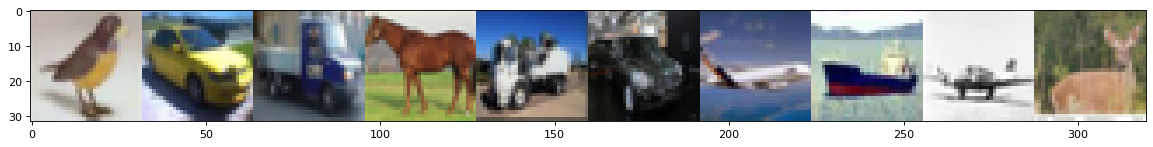

In [5]:
import torch

# Create a validation set loader.
batch_size = 10
_, val_loader = dataset.make_loaders(1, batch_size, only_val=True)

# Get a batch from the validation set.
inputs, labels = next(iter(val_loader))

# If we have a GPU, let's convert everything to CUDA so it's quicker.
if torch.cuda.is_available():
    inputs = inputs.cuda()
    labels = labels.cuda()
    model.cuda()

# Show the batch!
show(inputs)

We can also test the accuracy of the model on this set of inputs by comparing the model output to the ground-truth labels.

In [6]:
pred_labels = model(inputs).argmax(1)
print('Natural accuracy is', (labels == pred_labels).float().mean().item())

Natural accuracy is 0.9000000357627869


If the natural accuracy is very low on this batch of images, you might want to load a new set by re-running the two cells above.

## Generating perceptual adversarial examples

Next, let's generate some perceptual adversarial examples using Lagrange perceptual attack (LPA) with AlexNet bound $\epsilon = 0.5$. Other perceptual attacks (PPGD and Fast-LPA) are also found in the `perceptual_advex.perceptual_attacks` module, and they mostly share the same options.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


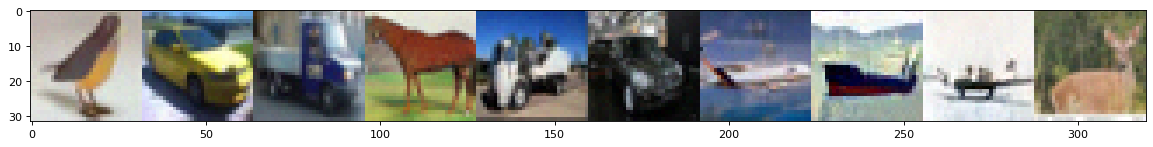

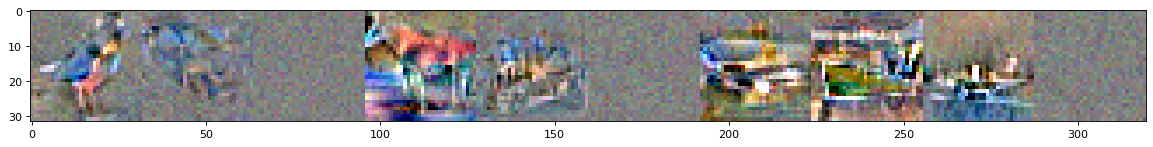

In [13]:
from perceptual_advex.perceptual_attacks import LagrangePerceptualAttack

attack = LagrangePerceptualAttack(
    model,
    num_iterations=10,
    # The LPIPS distance bound on the adversarial examples.
    bound=0.5,
    # The model to use for calculate LPIPS; here we use AlexNet.
    # You can also use 'self' to perform a self-bounded attack.
    lpips_model='alexnet_cifar',
)
adv_inputs = attack(inputs, labels)

# Show the adversarial examples.
show(adv_inputs)

# Show the magnified difference between the adversarial examples and unperturbed inputs.
show((adv_inputs - inputs) * 5 + 0.5)

Note that while the perturbations are sometimes large, the adversarial examples are still recognizable as the original image and do not appear too different perceptually.

We can calculate the accuracy of the classifier on the adversarial examples:

In [14]:
adv_pred_labels = model(adv_inputs).argmax(1)
print('Adversarial accuracy is', (labels == adv_pred_labels).float().mean().item())

Adversarial accuracy is 0.0


Even though this network has been trained to be robust to $L_2$ perturbations, there are still imperceptible perturbations found using LPA that fool it almost every time!

## Calculating LPIPS distance

Next, let's calculate the LPIPS distance between the adversarial examples we generated and the original inputs:

In [16]:
from perceptual_advex.distances import LPIPSDistance, L2Distance, LinfDistance
from perceptual_advex.perceptual_attacks import get_lpips_model

# LPIPS is based on the activations of a classifier, so we need to first
# load the classifier we'll use.
lpips_model = get_lpips_model('alexnet_cifar')
if torch.cuda.is_available():
    lpips_model.cuda()

# Now we can define a distance based on the model we loaded.
# We could also do LPIPSDistance(model) for self-bounded LPIPS.
lpips_distance = LPIPSDistance(lpips_model)
l2_distance = L2Distance()
linf_distance = LinfDistance()

# Finally, let's calculate the distance between the inputs and adversarial examples.
print(lpips_distance(inputs, adv_inputs))
print(l2_distance(inputs, adv_inputs))
print(linf_distance(inputs, adv_inputs))

tensor([0.4599, 0.3549, 0.2540, 0.4786, 0.3772, 0.2707, 0.4837, 0.4930, 0.4701,
        0.2738], device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor([1.4983, 1.0662, 0.5352, 2.5742, 1.3849, 0.5522, 2.4692, 2.9095, 2.1207,
        0.5640], device='cuda:0')
tensor([0.1605, 0.1031, 0.0344, 0.2501, 0.1270, 0.0346, 0.2459, 0.2876, 0.2198,
        0.0394], device='cuda:0')


Note that all the distances are within the bound of 0.5! At this bound, the adversarial perturbations should all have a similar level of perceptibility to the human eye.

Other distance measures between images are also defined in the `perceptual_advex.distances` package, including $L_\infty$, $L_2$, and SSIM.

## Generating non-perceptual adversarial examples

The `perceptual_advex` package also includes code to perform attacks based on other, narrower threat models like $L_\infty$ or $L_2$ distance and spatial transformations. The non-perceptual attacks are all in the `perceptual_advex.attacks` module. First, let's try an $L_2$ attack:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


L2 adversarial accuracy is 0.4000000059604645


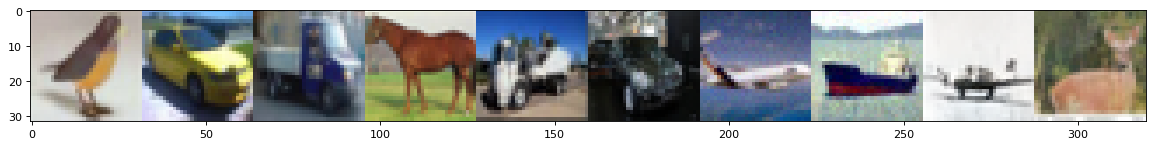

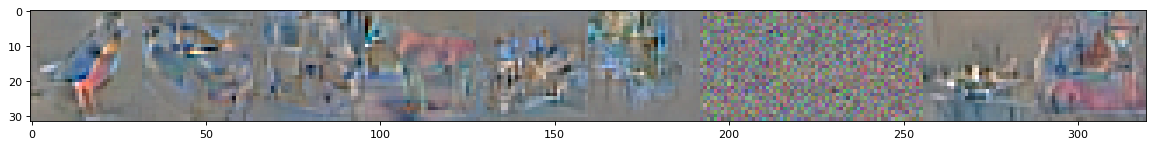

In [10]:
from perceptual_advex.attacks import L2Attack

attack = L2Attack(
    model,
    'cifar',
    # The bound is divided by 255, so this is equivalent to eps=1.
    bound=255,
)
l2_adv_inputs = attack(inputs, labels)

show(l2_adv_inputs)
show((l2_adv_inputs - inputs) * 5 + 0.5)

l2_adv_pred_labels = model(l2_adv_inputs).argmax(1)
print('L2 adversarial accuracy is', (labels == l2_adv_pred_labels).float().mean().item())

Here's an example of a spatial attack (StAdv):

/home/dingw/.local/lib/python3.10/site-packages/torch/nn/functional.py:4358: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/dingw/.local/lib/python3.10/site-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Spatial adversarial accuracy is 0.30000001192092896


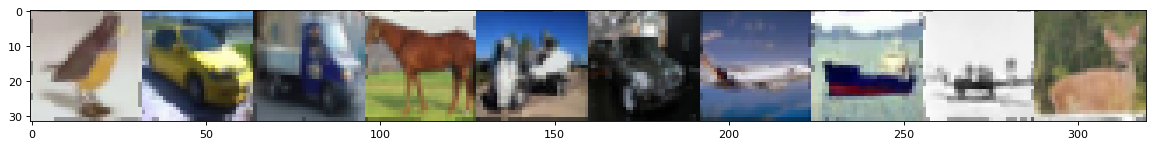

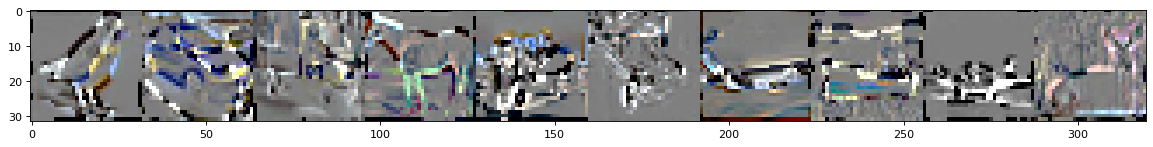

In [11]:
from perceptual_advex.attacks import StAdvAttack

attack = StAdvAttack(
    model,
    bound=0.02,
)
spatial_adv_inputs = attack(inputs, labels)

show(spatial_adv_inputs)
show((spatial_adv_inputs - inputs) * 5 + 0.5)

spatial_adv_pred_labels = model(spatial_adv_inputs).argmax(1)
print('Spatial adversarial accuracy is', (labels == spatial_adv_pred_labels).float().mean().item())

## Conclusion

That's pretty much it for how to use the package! As a final note, here is an overview of what each module contains:

 * `perceptual_advex.attacks`: non-perceptual attacks (e.g. $L_2$, $L_\infty$, spatial, recoloring, JPEG, etc.)
 * `perceptual_advex.datasets`: datasets (e.g. ImageNet-100, CIFAR-10, etc.)
 * `perceptual_advex.distances`: distance measures between images (e.g. LPIPS, SSIM, $L_2$)
 * `perceptual_advex.evaluation`: functions used for evaluating a trained model against attacks
 * `perceptual_advex.models`: classifier architectures (e.g. ResNet, AlexNet, etc.)
 * `perceptual_advex.perceptual_attacks`: perceptual attacks (e.g. LPA, PPGD, Fast-LPA)
 * `perceptual_advex.trades_wrn`: classifier architecture used by the TRADES defense (Zhang et al.)
 * `perceptual_advex.utilites`: various utilites, including `get_dataset_model` function to load a dataset and model